In [175]:
import cv2
import math

import matplotlib.pyplot as plt
import numpy as np

# Point to file source of video
VIDEO_LOCATION = "media/office_dance_vid.mp4"

In [112]:
def faircloth_tempo(flow: list) -> float:
    """
    An implementation of Ryan Faircloth's visual tempo detection algorithm. 
    https://stars.library.ucf.edu/cgi/viewcontent.cgi?article=4582&context=etd
    
    Args:
        flow (list): Optical Flow output from cv2.calcOpticalFlowFarneback
    
    Returns:
        movement (float): angle of movement vectors of the optical flow per each frame
    
    Raises:
        None
    """
    
    # slicing an numpy array is much nicer
    np_flow = np.array(flow)
    theta = np.arctan(np.mean(np_flow[...,0])/np.mean(np_flow[...,1]))
    if (np.pi/2 <= theta < np.pi):
        return (np.pi - theta)
    if (np.pi <= theta < 1.5*np.pi):
        return (3*np.pi - theta)
    return theta

In [163]:
def calculate_motion_vector_angles(
    video_location: str, 
    optical_flow_params: list = [0.5, 3, 15, 3, 5, 1.2, 0],
    convolve_param: int = 10
) -> np.array:
    """
    Run the optical flow Farneback algorithm pointed at a video file
    
    Args:
        video_location (string): location of the video file
        flow_params(list): "default" params for openCV Farneback
    
    Returns:
        movement (list): angles for movement vectors of the optical flow per each frame
    
    Raises:
        FileNotFoundError
    """
    capture = cv2.VideoCapture(video_location)
    success, previous_frame = capture.read()
    if not success:
        raise FileNotFoundError("Video file not found")

    previous_frame_greyscale = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)

    # A useful given
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    # initialize optical flow and angles lists
    optical_flow = list()
    motion_angles = list()
    
    for _ in range(frame_count - 1):
        _, current_frame = capture.read()
        current_frame_grayscale = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(
            previous_frame_greyscale, 
            current_frame_grayscale, 
            None, 
            *optical_flow_params
        )
        motion_angles.append(faircloth_tempo(flow))
        previous_frame_greyscale = current_frame_grayscale
        
    return np.convolve(motion_angles, np.ones(convolve_param), mode='full')

In [168]:
def build_beat_candidates(motion_angles: list, threshold: float = 5.0) -> list:
    """
    Filter only the strongest beat candidates and their location
    
    Args:
        motion_angles (list): output of the calculate_faircloth_tempo, a list of angles of motion vectors between frames
        threshold (int): barn door filter threshold
        
    Returns:
        beat_candidates (list): a filtered list of likely candidates
    
    Raises:
        None
    """    
    return [(i, j) for i, j in enumerate(motion_angles) if j > threshold]
    

In [169]:
motion_angles = calculate_motion_vector_angles(VIDEO_LOCATION)

KeyboardInterrupt: 

In [192]:
motion_angles.shape[0]

(629,)

In [172]:
beat_candidates = build_beat_candidates(motion_angles)

In [173]:
beat_candidates[:10]

[(18, 5.4479421973228455),
 (19, 6.096309393644333),
 (20, 6.658125728368759),
 (21, 7.201989233493805),
 (22, 7.747229278087616),
 (23, 8.39258474111557),
 (24, 9.28418505191803),
 (25, 7.204462468624115),
 (26, 5.049532771110535),
 (44, 5.706094950437546)]

In [253]:
def infer_faircloth_tempo(
    candidates: list,
    num_frames: int,
    tempos: list = list(range(40,180)),
) -> float:
    """
    Implementation of the Faircloth visual tempo algorithim
    https://stars.library.ucf.edu/cgi/viewcontent.cgi?article=4582&context=etd
    
    args:
        candidates (list of tuples): list of tuples of (frame_num, motion_vector_angle)
        num_frames (int): number of frames in video
        tempos (list): hypothesis tempos
    
    returns:
        tempo (float): tempo infered from the beat candidates
        score (float): probabilistic score for visual tempo 
        beats (list): array of frame numbers corresponding to the tracked visual beats
        
    raises:
        None
    """
    
    # initialize base params
    startup_period = math.ceil(0.75*num_frames)
    outer_tolerance_pre = 0.25
    outer_tolerance_post = 0.25
    inner_tolerance = 8
    total_salience = sum([i[1] for i in candidates])
    num_candidates = len(candidates)
    # use the agent_factory method to build out this list
    agents = []
    
    for tempo in tempos:
        for vote in candidates:
            if vote[0] < startup_period:
                agent = agent_factory(
                    tempo,
                    vote[0] + tempo,
                    [vote],
                    vote[1]/total_salience,
                    0,
                    1,
                )
                agents.append(agent)
                
    for vote in candidates:
        new_agents = []
        for agent in agents:
            pre_tolerance = math.ceil(outer_tolerance_pre*agent['interval'])
            post_tolerance = math.ceil(outer_tolerance_post*agent['interval'])
            timeout = agent['interval'] + post_tolerance
            while (vote[0] - agent['history'][len(agent['history'])-1][0]) > timeout:
                new_beat_onset = agent['history'][len(agent['history'])-1][0] + agent['interval']
                agent['history'].append((new_beat_onset, 0))
                agent['penalties'] += 1
                agent['prediction'] += agent['interval']
            
            tolerance_width = pre_tolerance + post_tolerance
            
            while ((agent['prediction'] + post_tolerance) < vote[0]):
                agent['prediction'] += agent['interval']
                
            if (agent['prediction'] - pre_tolerance <= vote[0]) \
            and (vote[0] <= agent['prediction'] + post_tolerance):
                if abs(agent['prediction'] - vote[0]) > inner_tolerance:
                    new_agents.append(agent)
                
                error = vote[0] - agent['prediction']
                real_error = error/tolerance_width
                agent['matches'] += 1
                agent['interval'] += real_error
                agent['prediction'] = vote[0] + agent['interval']
                agent['history'].append(vote)
                score_inc = (vote[1]/total_salience)*(1-abs(real_error))
                agent['score'] += score_inc
        agents.extend(new_agents)
    
    for agent in agents:
        agent['score'] = agent['score']*((1.0 - ((agent.get('penalties')*agent.get('interval'))/num_frames))\
        *agent.get('matches')/num_candidates)
    
    max_score = 0
    index_max = 100000000000
    for index, agent in enumerate(agents):
        if agent.get('score') > max_score:
            max_score = agent.get('score')
            index_max = index
    return agents[index_max].get('interval')/   

In [254]:
def agent_factory(
    interval: int = 0,
    prediction: float = 0.0,
    history: list = [],
    score: float = 0.0,
    penalties: int = 0,
    matches: int = 0
) -> dict:
    """
    A factory for agents in the tempo inference algo with defaults.
    
    """
    return dict(
        interval=interval,
        prediction=prediction,
        history=history,
        score=score,
        penalties=penalties,
        matches=matches,
    )

In [255]:
sum([i[1] for i in beat_candidates])

769.6945013497025

In [256]:
i = infer_faircloth_tempo(beat_candidates, motion_angles.shape[0])

In [257]:
i

{'interval': 40.86045262803923,
 'prediction': 656.8604526280392,
 'history': [(45, 7.527514189481735),
  (84, 5.510843396186829),
  (119, 6.663697823882103),
  (159.6404958677686, 0),
  (208, 6.26739227771759),
  (251, 5.911930799484253),
  (292.0826617034356, 0),
  (335, 6.736267566680908),
  (376.16605609403234, 0),
  (417.3321121880647, 0),
  (458.498168282097, 0),
  (499.66422437612937, 0),
  (536, 5.5823670625686646),
  (576.9464978908431, 0),
  (616, 5.296248108148575)],
 'score': 0.0025189332424952245,
 'penalties': 7,
 'matches': 8}

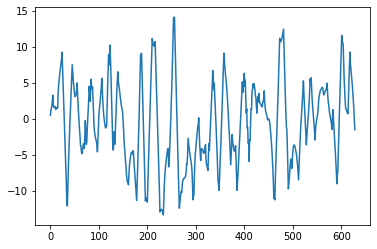

In [174]:
plt.plot(np.arange(motion_angles.shape[0]),motion_angles,)

In [258]:
40/629

0.06359300476947535

In [259]:
629/40

15.725